 # <center>Credit Card Fraud detection ~ Tackling Imbalanced data </center>
 

# Table of Contents

[1. Introduction](#section-one)

[2. Exploratory data analysis](#section-two)

[3. The metric fallacy](#section-three)

[4. Undersampling](#section-four)

[5. Oversampling](#section-five)

<a id="section-one"></a>
## 1. Introduction

### Introduction as described in data content ###

* The datasets contains transactions made by credit cards in September 2013 by european cardholders.

* This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 

* The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

* It contains only numerical input variables which are the result of a PCA transformation. But due to confidentiality issues,  the original features and more background information about the data has not been provided.

* Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

* Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 

* The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
#Importing libraries ##

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import random
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV,cross_val_predict,train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import recall_score, auc, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve, precision_recall_curve

# Any results you write to the current directory are saved as output.

/kaggle/input/creditcardfraud/creditcard.csv


Using TensorFlow backend.


## Reading in data

In [2]:
random.seed(1234)
df = pd.read_csv("../input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
### Helper functions ###

### scaling ###

def feat_scale(df,col):
    sc = StandardScaler()
    df[col+"_scaled"] = sc.fit_transform(df[col].values.reshape(-1,1))
    df.drop(col, axis =1 , inplace = True)
    return df


### PCA with 2 components  ###

def pcanalysis(df, cols, n_comp):
            pca = PCA(n_components = n_comp)
            principalComponents = pca.fit_transform(df[cols])
            pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
            pca_df = pd.concat([pca_df, df[['Class']]], axis = 1)
            var = np.round((pca.explained_variance_ratio_*100),2)
            ax = sns.scatterplot(x = pca_df['PC1'], y = pca_df['PC2'], hue = pca_df['Class'])
            ax.set(xlabel="PC1", ylabel = "PC2")
            plt.show()
            print("%variance explained by PC1:{}".format(np.round((pca.explained_variance_ratio_[0]*100),2)))
            print("%variance explained by PC2:{}".format(np.round((pca.explained_variance_ratio_[1]*100),2)))
            return pca_df

<a id="section-two"></a>
## 2. Exploratory data analysis

In [4]:
df[['Time','Amount']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,94813.859575,47488.145955,0.0,54201.5,84692.0,139320.500,172792.00
Amount,284807.0,88.349619,250.120109,0.0,5.6,22.0,77.165,25691.16


In [5]:
df.shape

(284807, 31)

#No missing values !!!

In [6]:
df.isnull().sum().max()

0

In [7]:
### checking dtypes in the dataset ###

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

No mixed datatypes!!

In [8]:
### checking the counts of fraud and non-fraud records ###

df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

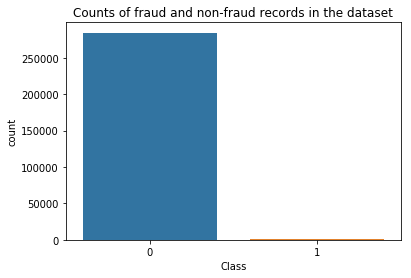

In [9]:
ax = sns.countplot(x="Class", data= df)
plt.title("Counts of fraud and non-fraud records in the dataset")
plt.show()

In [10]:
summary = df.Class.value_counts()
summary

0    284315
1       492
Name: Class, dtype: int64

In [11]:
print("% of non-fraud transactions = ",(summary[0]*(100/df.shape[0])) )
print("% of fraud transactions = ", (summary[1]*(100/df.shape[0])))

% of non-fraud transactions =  99.827251436938
% of fraud transactions =  0.1727485630620034


So we have 492 cases of fraud (0.17%) and ~284k cases of nonfraud (99.83%). This is a highly imbalanced dataset!!  This can lead to overfitting of our models.

Columns V1-V28 are already scaled. Let's examine the distribution of Time and amount columns.

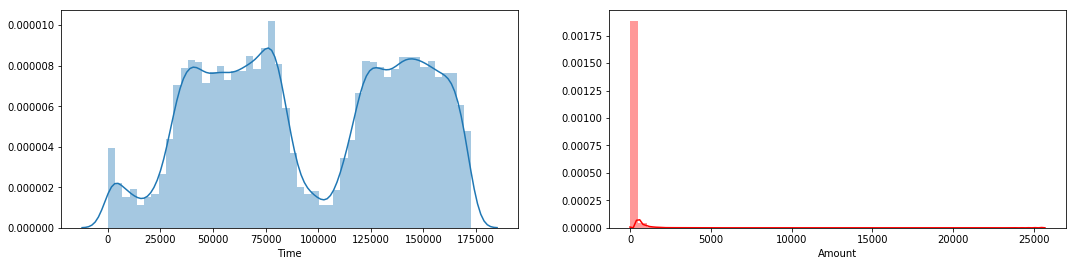

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.distplot(
    df['Time'],
    ax=axes[0])
            
sns.distplot(
    df['Amount'],
    ax=axes[1], color = 'red')


plt.show()

Both distributions are highly skewed and need scaling.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Fraudulent transactions over time')

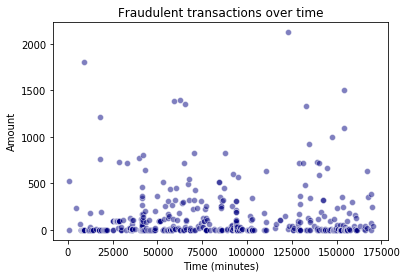

In [13]:
### Distribution of fraud transactions Amount with time ###

fraud = df.loc[df.Class == 1]
fraud.Timemin = (fraud.Time)/60
sns.scatterplot(x = 'Time', y='Amount', data = fraud, alpha = 0.5,color = 'navy')
plt.xlabel('Time (minutes)')
plt.title("Fraudulent transactions over time")

In [14]:
fraud.Amount.describe().transpose()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [15]:
non_fraud = df.loc[df.Class == 0]
non_fraud.Amount.describe().transpose()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Fraud transactions have higher mean Amount and lower median amount, as compared to non-fraud transactions. 

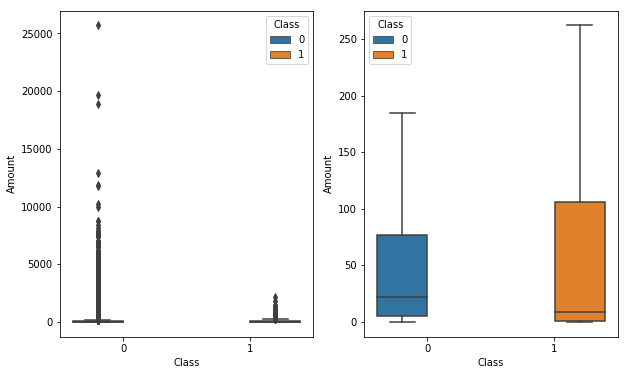

In [16]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.boxplot(x="Class", y="Amount", ax = ax1,data = df, showfliers = True, hue = 'Class')
sns.boxplot(x="Class", y="Amount", ax = ax2, data = df, showfliers = False, hue = 'Class')
plt.show()

## Density plot of other features for the two classes:

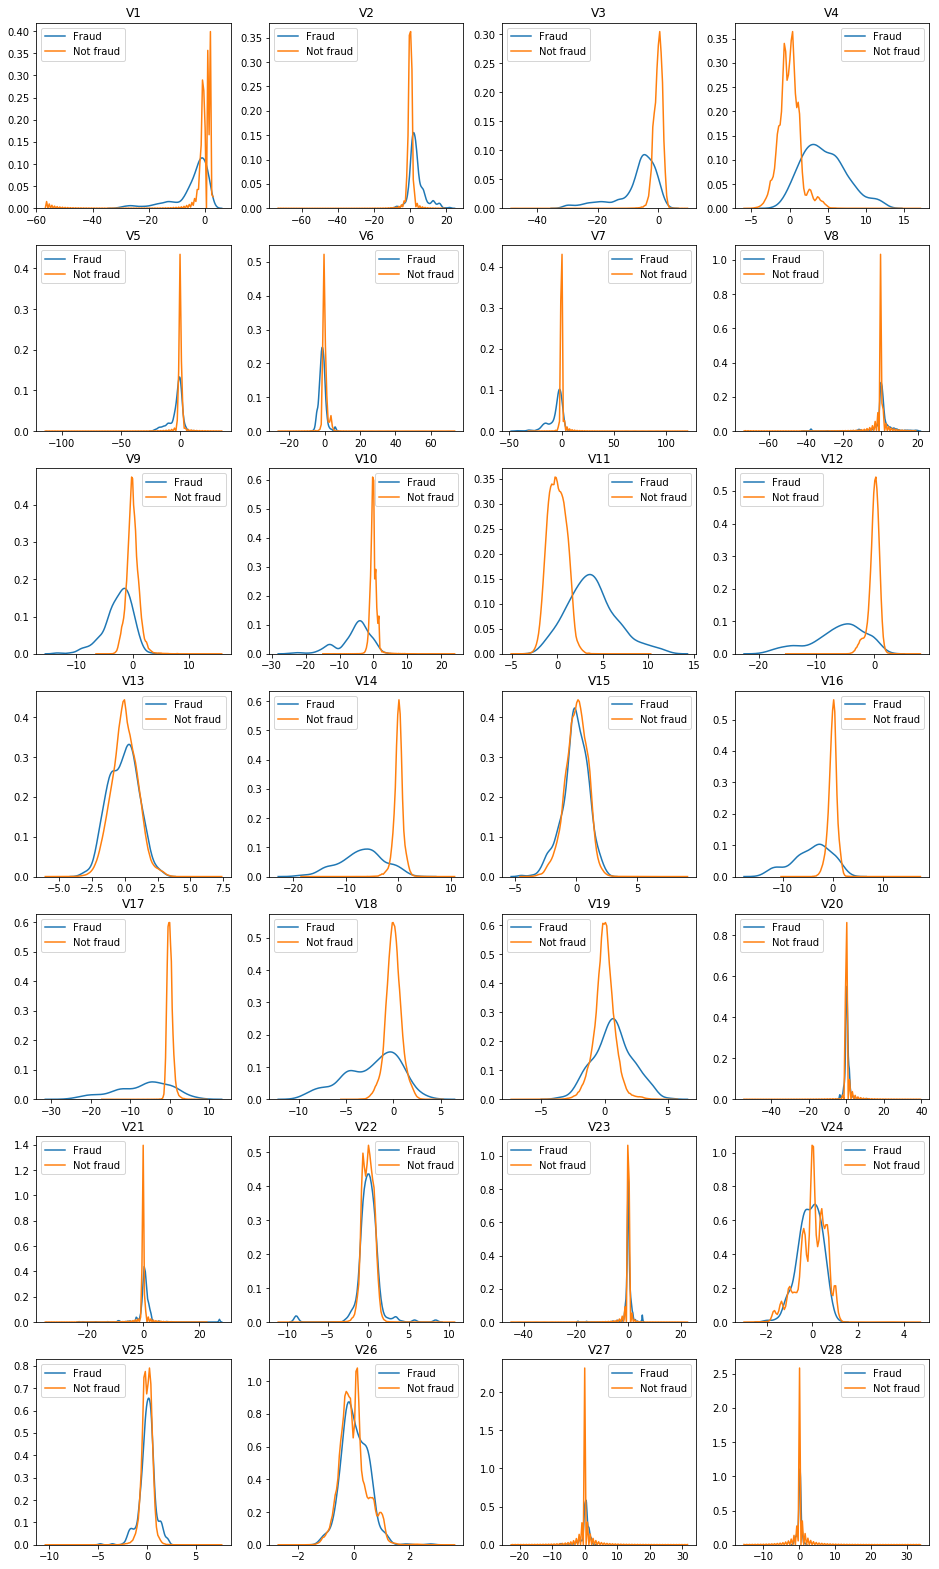

In [17]:
feat = df.drop(['Time', 'Amount','Class'], axis = 1).columns.tolist()
fig = plt.figure(figsize = (16,28))
for n, col in enumerate(feat):
        ax1 = fig.add_subplot(7,4,n+1)
        sns.kdeplot(fraud[col], label ='Fraud')
        sns.kdeplot(non_fraud[col], label = 'Not fraud')
        plt.title(col)
        
plt.show()  
    


In [18]:
### scaling Time and Amount features ###

df1 = df.copy()
feat_scale(df1,'Time')
feat_scale(df1,'Amount')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Time_scaled,Amount_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.996583,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.996583,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-1.996562,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-1.996562,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-1.996541,-0.073403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,1.641931,-0.350151
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,1.641952,-0.254117
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,1.641974,-0.081839
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,1.641974,-0.313249


In [19]:
features = df1.drop(['Class'], axis = 1).columns.tolist()
features


['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Time_scaled',
 'Amount_scaled']

*Let's visualize the dataset using dimensionality reduction:

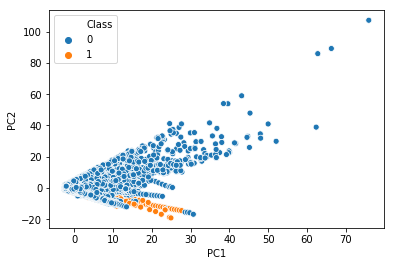

%variance explained by PC1:12.09
%variance explained by PC2:9.65


In [20]:
pca_2D = pcanalysis(df1, features, 2)


<a id="section-three"></a>

## 3. The metric fallacy
Using model accuracy as a metric to evaluate model performance for imbalanced datasets leads to misleading conclusions, since the classifier overfits to the most frequent class. We could use precision/recall, confusion matrix, ROC curves instead.



 How do deal with imbalanced datasets?

Following are few approaches to deal with imbalanced datasets like the present one:

 a. Undersampling

Random sampling of nonfraud records are done and 492 records are selected to get a number which is same as number of fraud records. Both these sets are then concatenated to generate a new train set. In case of undersampling we could suffer from information loss.

 b. Oversampling 

In this case more records are added from the fraud cases. But this addition could also lead to overfitting. 




We need to do undersampling on df1 and train our model. However, testing would still be on the original dataframe df.


Let's visualize what happens on undersampling:

In [21]:
### Train/test split on original dataset ###

X_train_origin, X_test_origin, y_train_origin, y_test_origin = train_test_split(df.drop(['Class'],axis =1), df['Class'], test_size = 0.2, random_state = 42)


In [22]:
#### Undersampling on train set ###

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train_origin,y_train_origin)
under_df = pd.concat([X_rus,y_rus], axis = 1)
under_df.shape

(788, 31)

In [23]:
X_under = under_df.drop(['Class'], axis =1)
y_under = under_df['Class']

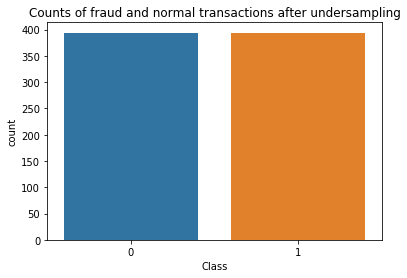

In [24]:
ax = sns.countplot(x="Class", data= under_df)
plt.title("Counts of fraud and normal transactions after undersampling")
plt.show()

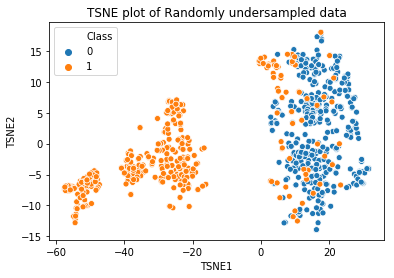

In [25]:
X_tsne = X_under.copy()
X_tsne = feat_scale(X_tsne,"Time")
X_tsne = feat_scale(X_tsne, "Amount")
tsne = TSNE(n_components=2, perplexity=50.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, random_state=0)
tsne_out = tsne.fit_transform(X_tsne)
td = pd.DataFrame(data = tsne_out, columns = ['TSNE1', 'TSNE2'])
td = pd.concat([td, under_df[['Class']]], axis = 1)
ax1 = sns.scatterplot(x = td['TSNE1'], y = td['TSNE2'], hue = td['Class'])
ax1.set(xlabel="TSNE1", ylabel = "TSNE2")
ax1.set_title('TSNE plot of Randomly undersampled data')
plt.show()

In [26]:
train = pd.concat([X_train_origin, y_train_origin], axis =1)

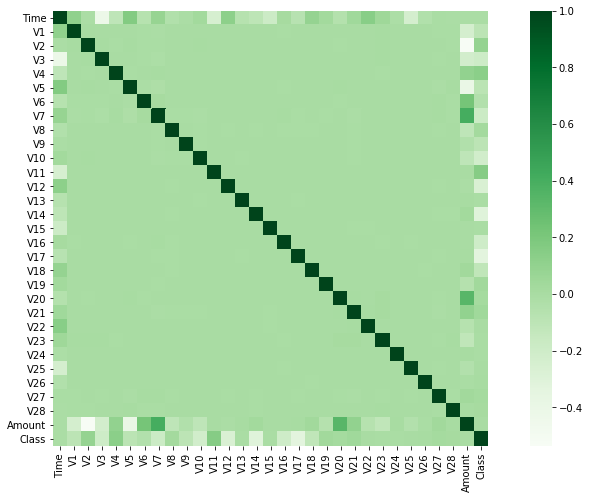

In [27]:
## correlations ##

fig, ax = plt.subplots(figsize=(15,8))      
sns.heatmap(train.corr(), xticklabels = True, yticklabels = True, square=True,  ax = ax, cmap = "Greens")
plt.show()

In [28]:
### Correlations of all features with the target ###
print(train.corr().Class)

Time     -0.013347
V1       -0.095316
V2        0.089084
V3       -0.188841
V4        0.134112
V5       -0.089921
V6       -0.044696
V7       -0.181737
V8        0.024712
V9       -0.097186
V10      -0.215498
V11       0.155963
V12      -0.263396
V13      -0.002034
V14      -0.306055
V15      -0.004357
V16      -0.197413
V17      -0.326790
V18      -0.111447
V19       0.035543
V20       0.017866
V21       0.041905
V22       0.000824
V23      -0.005989
V24      -0.007302
V25       0.002115
V26       0.005436
V27       0.019654
V28       0.010741
Amount    0.003807
Class     1.000000
Name: Class, dtype: float64


In [29]:
X_test_origin.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

running cross validation with baseline model

In [30]:
### cross validation ##

def crossval(X_train_origin, y_train_origin):
    dictli = [{"name": "KNeighborsClassifier", "estimator":KNeighborsClassifier()}, 
          {"name": "LogisticRegression", "estimator":LogisticRegression(random_state = 42)}, 
          {"name": "RandomForestClassifier", "estimator":RandomForestClassifier(random_state = 42)}]
    for i in dictli:
        score = cross_val_score(i['estimator'], X_train_origin, y_train_origin, cv= 10)
        print(i['name'],"training score of:",  round(score.mean(), 2) * 100, "% accuracy score")
    return dictli
accuracy = crossval(X_train_origin, y_train_origin)

KNeighborsClassifier training score of: 100.0 % accuracy score


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression training score of: 100.0 % accuracy score
RandomForestClassifier training score of: 100.0 % accuracy score


We will now further refine the model by tuning the hyperparameters:

<a id="section-four"></a>
## 4. Undersampling 

In [31]:
## Pipeline and GridSearchCV ##

model = Pipeline([
        ('sampling', RandomUnderSampler(random_state = 0)),
        ('scaling', StandardScaler()),
        ('classification', LogisticRegression())
    ])


#lr = LogisticRegression()
#pipe = make_pipeline(StandardScaler(), lr) 
param = {'classification__C': [0.001, 0.01, 0.1,  10, 100]}
grid_search_log = GridSearchCV(model, param, scoring='roc_auc',refit=True,  cv= 5)
#grid_search_log = GridSearchCV(pipe, param_grid=param, scoring='roc_auc',refit=True,  cv= 5)
grid_search_log.fit(X_train_origin, y_train_origin)
print(grid_search_log.best_estimator_)
log_best = grid_search_log.best_estimator_
resultsdf = pd.DataFrame(grid_search_log.cv_results_)
resultsdf

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Pipeline(memory=None,
         steps=[('sampling',
                 RandomUnderSampler(random_state=0, replacement=False,
                                    sampling_strategy='auto')),
                ('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classification',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.163232,0.006605,0.036493,0.002267,0.001,{'classification__C': 0.001},0.971377,0.953431,0.939311,0.968860,0.973615,0.961319,0.013083,5
1,0.167783,0.000578,0.035616,0.000482,0.01,{'classification__C': 0.01},0.980607,0.964659,0.956531,0.979822,0.974106,0.971145,0.009265,4
2,0.171912,0.000732,0.035674,0.000294,0.1,{'classification__C': 0.1},0.984093,0.970266,0.959452,0.984504,0.972549,0.974173,0.009378,3
3,0.211939,0.003483,0.035712,0.000625,10,{'classification__C': 10},0.984971,0.972113,0.964763,0.987015,0.975806,0.976934,0.008232,2
4,0.213491,0.002451,0.035796,0.000792,100,{'classification__C': 100},0.986019,0.974075,0.966916,0.984514,0.977330,0.977771,0.007003,1


In [32]:
model = Pipeline([
        ('sampling', RandomUnderSampler(random_state = 0)),
        ('scaling', StandardScaler()),
        ('classification', KNeighborsClassifier())
    ])


#pipe = make_pipeline(StandardScaler(), KNeighborsClassifier()) 
param = {'classification__n_neighbors': range(1,20,2), 'classification__weights': ["distance", "uniform"],
         'classification__algorithm': ["ball_tree", "kd_tree", "brute"]}
grid_search_knn = GridSearchCV(model, param_grid=param, scoring='roc_auc',refit=True,  cv= 5)
grid_search_knn.fit(X_train_origin, y_train_origin)
print(grid_search_knn.best_estimator_)
knn_best = grid_search_knn.best_estimator_
resultsdf = pd.DataFrame(grid_search_knn.cv_results_)
resultsdf

Pipeline(memory=None,
         steps=[('sampling',
                 RandomUnderSampler(random_state=0, replacement=False,
                                    sampling_strategy='auto')),
                ('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classification',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=19, p=2,
                                      weights='distance'))],
         verbose=False)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__algorithm,param_classification__n_neighbors,param_classification__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.122664,0.002893,1.131644,0.004432,ball_tree,1,distance,"{'classification__algorithm': 'ball_tree', 'cl...",0.916384,0.876658,0.898305,0.902348,0.924028,0.903544,0.016348,55
1,0.122065,0.001356,1.132870,0.009150,ball_tree,1,uniform,"{'classification__algorithm': 'ball_tree', 'cl...",0.916384,0.876658,0.898305,0.902348,0.924028,0.903544,0.016348,55
2,0.124523,0.006140,1.186503,0.023008,ball_tree,3,distance,"{'classification__algorithm': 'ball_tree', 'cl...",0.948648,0.923998,0.933313,0.947072,0.948868,0.940380,0.010035,49
3,0.123477,0.001352,1.196665,0.010387,ball_tree,3,uniform,"{'classification__algorithm': 'ball_tree', 'cl...",0.948354,0.921863,0.932523,0.945475,0.946159,0.938874,0.010161,52
4,0.122144,0.000577,1.216843,0.015257,ball_tree,5,distance,"{'classification__algorithm': 'ball_tree', 'cl...",0.959366,0.929759,0.943724,0.953805,0.952895,0.947910,0.010371,43
5,0.121456,0.001013,1.215308,0.013471,ball_tree,5,uniform,"{'classification__algorithm': 'ball_tree', 'cl...",0.957654,0.927981,0.944247,0.953100,0.951254,0.946847,0.010373,46
6,0.122686,0.001319,1.258907,0.032713,ball_tree,7,distance,"{'classification__algorithm': 'ball_tree', 'cl...",0.960181,0.926874,0.954039,0.965855,0.951303,0.951651,0.013373,31
7,0.122107,0.001118,1.253588,0.023940,ball_tree,7,uniform,"{'classification__algorithm': 'ball_tree', 'cl...",0.958560,0.924837,0.954300,0.966732,0.950598,0.951005,0.014144,34
8,0.124815,0.003348,1.302641,0.034350,ball_tree,9,distance,"{'classification__algorithm': 'ball_tree', 'cl...",0.960296,0.923348,0.955314,0.966563,0.948547,0.950814,0.014951,37
9,0.123535,0.002586,1.280885,0.026610,ball_tree,9,uniform,"{'classification__algorithm': 'ball_tree', 'cl...",0.959230,0.920872,0.953097,0.967762,0.947560,0.949705,0.015901,40


In [33]:
model = Pipeline([
        ('sampling', RandomUnderSampler(random_state = 0)),
        ('scaling', StandardScaler()),
        ('classification', RandomForestClassifier())
    ])

#pipe = make_pipeline(StandardScaler(), RandomForestClassifier()) 
param = {'classification__max_depth': [2, 5, 10], 'classification__min_samples_leaf':[1, 5, 8],
         "classification__criterion": ["entropy", "gini"], "classification__min_samples_split": [2, 3, 5]}
grid_search_rf = GridSearchCV(model, param_grid=param, scoring='roc_auc',refit=True,  cv= 5)
grid_search_rf.fit(X_train_origin, y_train_origin)
print(grid_search_rf.best_estimator_)
rf_best = grid_search_rf.best_estimator_
resultsdf = pd.DataFrame(grid_search_rf.cv_results_)
resultsdf

Pipeline(memory=None,
         steps=[('sampling',
                 RandomUnderSampler(random_state=0, replacement=False,
                                    sampling_strategy='auto')),
                ('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classification',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=10, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__criterion,param_classification__max_depth,param_classification__min_samples_leaf,param_classification__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.427593,0.002524,0.202269,0.001641,entropy,2,1,2,"{'classification__criterion': 'entropy', 'clas...",0.975069,0.976436,0.959994,0.983259,0.971877,0.973327,0.007632,37
1,0.438216,0.028230,0.202141,0.003231,entropy,2,1,3,"{'classification__criterion': 'entropy', 'clas...",0.977435,0.974818,0.954373,0.980568,0.971173,0.971673,0.009184,43
2,0.427050,0.003906,0.202889,0.003999,entropy,2,1,5,"{'classification__criterion': 'entropy', 'clas...",0.976524,0.974613,0.957510,0.977861,0.966038,0.970509,0.007694,49
3,0.438117,0.011630,0.206617,0.007479,entropy,2,5,2,"{'classification__criterion': 'entropy', 'clas...",0.975176,0.974143,0.966484,0.978545,0.966988,0.972267,0.004748,41
4,0.430782,0.006303,0.202490,0.001282,entropy,2,5,3,"{'classification__criterion': 'entropy', 'clas...",0.975594,0.973116,0.964953,0.977651,0.963536,0.970970,0.005694,45
5,0.425421,0.002018,0.201824,0.002065,entropy,2,5,5,"{'classification__criterion': 'entropy', 'clas...",0.978416,0.970680,0.961498,0.979366,0.962337,0.970459,0.007602,50
6,0.428806,0.006217,0.212130,0.009600,entropy,2,8,2,"{'classification__criterion': 'entropy', 'clas...",0.977384,0.977231,0.957216,0.980616,0.967002,0.971890,0.008649,42
7,0.425904,0.002729,0.203400,0.002053,entropy,2,8,3,"{'classification__criterion': 'entropy', 'clas...",0.976398,0.975212,0.953665,0.981332,0.967986,0.970919,0.009625,47
8,0.424349,0.001839,0.202962,0.001729,entropy,2,8,5,"{'classification__criterion': 'entropy', 'clas...",0.975408,0.976095,0.960209,0.982713,0.968010,0.972487,0.007706,38
9,0.507595,0.005856,0.278747,0.003639,entropy,5,1,2,"{'classification__criterion': 'entropy', 'clas...",0.982580,0.978549,0.965642,0.988165,0.972698,0.977527,0.007801,26


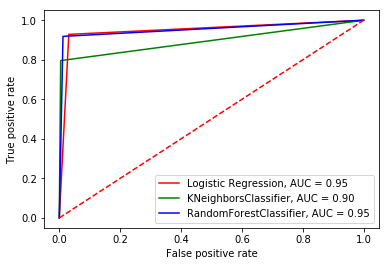

In [34]:
### ROC curve using test set ###

log_fpr, log_tpr, log_thresh = roc_curve(y_test_origin,log_best.predict(X_test_origin))
knn_fpr, knn_tpr, knn_thresh = roc_curve(y_test_origin, knn_best.predict(X_test_origin))
rf_fpr, rf_tpr, rf_thresh = roc_curve(y_test_origin, rf_best.predict(X_test_origin))
def roc_compare_plot(log_fpr, log_tpr,knn_fpr, knn_tpr,rf_fpr, rf_tpr ):
    roc_auc = auc(log_fpr,log_tpr)
    plt.plot(log_fpr, log_tpr, color ='red', label = 'Logistic Regression, AUC = %0.2f'% roc_auc)
    roc_auc_knn = auc(knn_fpr,knn_tpr)
    plt.plot(knn_fpr, knn_tpr, color ='green', label = 'KNeighborsClassifier, AUC = %0.2f'% roc_auc_knn)
    roc_auc_rf = auc(rf_fpr,rf_tpr)
    plt.plot(rf_fpr, rf_tpr, color ='blue', label = 'RandomForestClassifier, AUC = %0.2f'% roc_auc_rf)
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
roc_compare_plot(log_fpr, log_tpr,knn_fpr, knn_tpr,rf_fpr, rf_tpr)
    

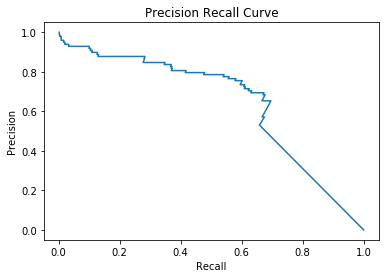

In [35]:
### Precision recall curve using test set using logistic regression###

y_pred_prob = log_best.predict_proba(X_test_origin)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test_origin, y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()


Recall: 0.9285714285714286
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.93      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962

[[55084  1780]
 [    7    91]]


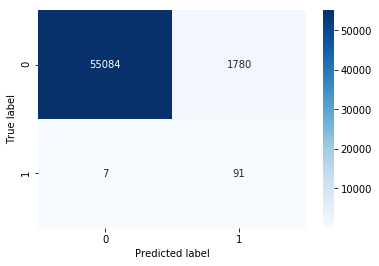

In [36]:
### checking on  test set using logistic regression ###


y_pred = log_best.predict(X_test_origin)
print("\nRecall:",recall_score(y_test_origin,y_pred))
print(classification_report(y_test_origin, y_pred))
conf_matrix = confusion_matrix(y_test_origin,y_pred)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


Recall: 0.9183673469387755
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.92      0.21        98

    accuracy                           0.99     56962
   macro avg       0.56      0.95      0.60     56962
weighted avg       1.00      0.99      0.99     56962

[[56174   690]
 [    8    90]]


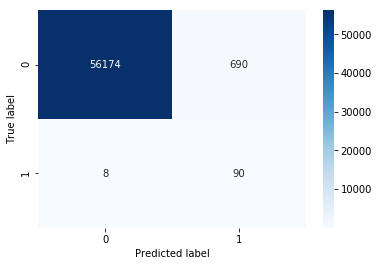

In [37]:
### checking on  test set using RandomForest ###


y_pred = rf_best.predict(X_test_origin)
print("\nRecall:",recall_score(y_test_origin,y_pred))
print(classification_report(y_test_origin, y_pred))
conf_matrix = confusion_matrix(y_test_origin,y_pred)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## Conclusions from undersampling 

1. On original test set when we use Random Forest, although recall = 0.89 , precision is very low with undersampling
3. Hence, I will try out oversampling using SMOTE(Synthetic Minority Oversampling technique)

credits to https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/    for explaining SMOTE so well !!!!

<a id="section-five"></a>
## 5. Oversampling

** Random Forest with Oversampling SMOTE**

In [38]:
random.seed(1234)
data = pd.read_csv("../input/creditcardfraud/creditcard.csv")


In [39]:
X_data = data.drop(["Class"], axis = 1)
y_data = data[['Class']]

In [40]:
X_tr_origin, X_holdout, y_tr_origin, y_holdout = train_test_split(X_data, y_data, test_size = 0.2, random_state = 42)

In [41]:
colnames = X_tr_origin.columns
colnames

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [42]:
print("Length of training dataset:", len(X_tr_origin))
print("Length of test dataset:", len(X_holdout))

Length of training dataset: 227845
Length of test dataset: 56962


In [43]:
### GridsearchCV and pipeline ###

model = Pipeline([
        ('sampling', SMOTE(random_state = 0)),
        ('scaling', StandardScaler()),
        ('classification', RandomForestClassifier(n_estimators = 10))
    ])


#pipe = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 10)) 
param = {'classification__max_depth': [2, 5, 10], 'classification__min_samples_leaf':[1, 5, 8],
        "classification__criterion": ["entropy", "gini"], "classification__min_samples_split": [2, 3, 5]}
grid_search_rf = GridSearchCV(model, param, scoring='roc_auc',refit=True,  cv= 5)
#grid.fit(X, y)
#grid_search_rf = GridSearchCV(pipe, param_grid=param, scoring='roc_auc',refit=True,  cv= 5)
grid_search_rf.fit(X_tr_origin, y_tr_origin.values.ravel())
print(grid_search_rf.best_estimator_)
rf_best = grid_search_rf.best_estimator_
resultsdf = pd.DataFrame(grid_search_rf.cv_results_)
resultsdf

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=0,
                       sampling_strategy='auto')),
                ('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classification',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=5, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                   

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__criterion,param_classification__max_depth,param_classification__min_samples_leaf,param_classification__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.449507,0.067052,0.040206,0.000539,entropy,2,1,2,"{'classification__criterion': 'entropy', 'clas...",0.963396,0.955568,0.965586,0.978405,0.967078,0.966007,0.007360,42
1,9.457330,0.064837,0.040163,0.000835,entropy,2,1,3,"{'classification__criterion': 'entropy', 'clas...",0.977046,0.961129,0.950248,0.963646,0.961386,0.962691,0.008555,47
2,9.779070,0.463918,0.041028,0.000772,entropy,2,1,5,"{'classification__criterion': 'entropy', 'clas...",0.969018,0.963150,0.954491,0.967449,0.963451,0.963512,0.005046,45
3,9.428084,0.053970,0.040323,0.000765,entropy,2,5,2,"{'classification__criterion': 'entropy', 'clas...",0.979273,0.960053,0.950862,0.975616,0.959508,0.965063,0.010686,43
4,9.409570,0.098687,0.041694,0.003280,entropy,2,5,3,"{'classification__criterion': 'entropy', 'clas...",0.975198,0.972514,0.953085,0.975132,0.957157,0.966617,0.009524,39
5,9.452772,0.057556,0.039864,0.000803,entropy,2,5,5,"{'classification__criterion': 'entropy', 'clas...",0.975597,0.970529,0.961810,0.975273,0.949326,0.966507,0.009929,40
6,9.451428,0.057730,0.040465,0.000790,entropy,2,8,2,"{'classification__criterion': 'entropy', 'clas...",0.979076,0.965020,0.954041,0.976528,0.956654,0.966264,0.010127,41
7,9.607701,0.092833,0.040912,0.000459,entropy,2,8,3,"{'classification__criterion': 'entropy', 'clas...",0.976459,0.962729,0.965827,0.977747,0.958077,0.968168,0.007712,36
8,9.701848,0.094486,0.041492,0.002443,entropy,2,8,5,"{'classification__criterion': 'entropy', 'clas...",0.975686,0.941219,0.963712,0.962435,0.949180,0.958446,0.012029,52
9,21.694043,0.145435,0.051807,0.001032,entropy,5,1,2,"{'classification__criterion': 'entropy', 'clas...",0.982982,0.977806,0.981170,0.992730,0.968105,0.980558,0.007963,1



Recall: 0.8673469387755102
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.22      0.87      0.35        98

    accuracy                           0.99     56962
   macro avg       0.61      0.93      0.67     56962
weighted avg       1.00      0.99      1.00     56962

[[56564   300]
 [   13    85]]


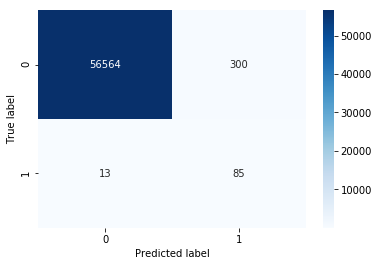

In [44]:
### checking on holdout set ###

y_pred = rf_best.predict(X_holdout)
print("\nRecall:",recall_score(y_holdout,y_pred))
print(classification_report(y_holdout, y_pred))
conf_matrix = confusion_matrix(y_holdout,y_pred)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## Conclusions from oversampling

1. On original test set when we use Random Forest, precision improves immensly as compared to undersampling+RF.
2. recall = 0.90 , when using RF+SMOTE
3. Hence SMOTE is better as compared to undersampling for this dataset


## SMOTE+Support Vector Classifier

In [45]:
### GridsearchCV and pipeline ###

model = Pipeline([
        ('sampling', SMOTE(random_state = 0)),
        ('scaling', StandardScaler()),
        ('classification', SVC(random_state = 42))
    ])


#pipe = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 10)) 
param = {'classification__C': [1]}
grid_search_sv = GridSearchCV(model,param,  scoring='roc_auc',refit=True,  cv= 5)
#grid.fit(X, y)
#grid_search_rf = GridSearchCV(pipe, param_grid=param, scoring='roc_auc',refit=True,  cv= 5)
grid_search_sv.fit(X_tr_origin, y_tr_origin.values.ravel())
print(grid_search_sv.best_estimator_)
sv_best = grid_search_sv.best_estimator_
resultsdf = pd.DataFrame(grid_search_sv.cv_results_)
resultsdf

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=0,
                       sampling_strategy='auto')),
                ('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classification',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=42, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,697.563556,53.573203,28.96571,2.090952,1,{'classification__C': 1},0.969109,0.947017,0.935936,0.972974,0.952662,0.955539,0.013808,1



Recall: 0.8163265306122449
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.39      0.82      0.52        98

    accuracy                           1.00     56962
   macro avg       0.69      0.91      0.76     56962
weighted avg       1.00      1.00      1.00     56962

[[56737   127]
 [   18    80]]


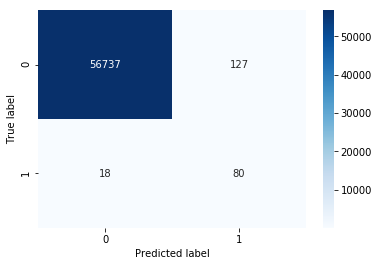

In [46]:
### checking on holdout set ###

y_pred = sv_best.predict(X_holdout)
print("\nRecall:",recall_score(y_holdout,y_pred))
print(classification_report(y_holdout, y_pred))
conf_matrix = confusion_matrix(y_holdout,y_pred)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Precision improves with SVM+Oversampling